In [2]:
import os
import shutil
import numpy
import math
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.autograd import Variable
from pytorch_fid import inception
from torchvision.models.inception import inception_v3
from PIL import Image
from scipy import linalg
from scipy.stats import entropy
import wget
import patoolib

In [3]:
os.mkdir('unfiltered')
data_path = r'./unfiltered'
os.mkdir('filtered')
target_path= r'./filtered'
os.mkdir('examples')
os.mkdir('trained_models')

In [4]:
URL = "https://drive.google.com/u/0/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t" 
response = wget.download(URL, "thecarconnectionpicturedataset.rar")

In [5]:
patoolib.extract_archive("thecarconnectionpicturedataset.rar", outdir= "unfiltered/")

patool: Extracting thecarconnectionpicturedataset.rar ...
patool: running /usr/bin/unrar x -- /content/thecarconnectionpicturedataset.rar
patool:     with cwd='unfiltered/'
patool: ... thecarconnectionpicturedataset.rar extracted to `unfiltered/'.


'unfiltered/'

In [6]:
listOfFiles = os.listdir(data_path)
car_types= ['Convertible','Pickup','Station Wagon','4dr','3dr','2dr','SUV','Van']  # reszta to 'nan'
car_dictionary = dict.fromkeys(car_types)
for type_of_car in car_types:
    str_match = [s for s in listOfFiles if type_of_car+"_" in s]
    car_dictionary[type_of_car] = len(str_match)
    # ponizej tworzenie folderow z posortowanymi juz zdjeciami typow, czyli tzw. klas
    os.mkdir(os.path.join(target_path,type_of_car))
    target_dir = os.path.join(target_path,type_of_car)
    for fname in str_match:
        # przenoszenie plikow do wlasciwych folderow
        shutil.move(os.path.join(data_path,fname), target_dir)

In [7]:
cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

if cuda:
  import cupy as cp
  print("You are working with CUDA")
  device=torch.device('cuda')
else:
  import numpy as cp
  print("You are working with CPU")
  device = torch.device('cpu')

You are working with CUDA


In [8]:
## inicjalizacja parametrow
number_of_classes = len(car_types)
number_of_epochs = 10

image_size_width = 64
image_size_height = 64
image_size=(image_size_width,image_size_height)
channels = 3 # RGB
img_shape_tuple = (channels, image_size_width, image_size_height)
img_shape = cp.array([channels, image_size_width, image_size_height])

batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
latent_size = 128  # rozmiar wektora wejsciowego do generatora

# wybor rozmiaru kerneli dla warstaw konwolucyjnych sieci: 4, 6 lub 8
kernel_param = 4
padding_param = int((kernel_param-4)/2) +1

# wybor, ile wierszy i kolumn obrazow samochodow ma zostac wygenerowanych 
# (zestawienie w macierzy kwadratowej o rozmiarze NxN)
N=5

# konwersja obrazu do tensora z odpowiednimi warunkami 
train_ds = ImageFolder(target_path, transform=T.Compose([
    T.Resize((image_size_width,image_size_height)),
    T.ToTensor(),
    T.Normalize(*stats)]))

# zbiór treningowy
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

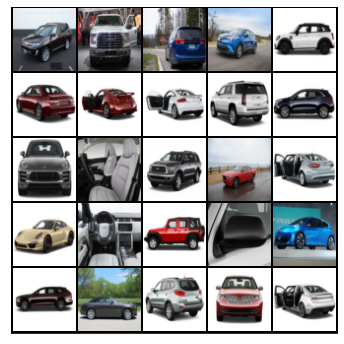

In [9]:
## pokazanie przykladowego batcha ze zdjeciami samochodow

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=N*N):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=N).permute(1, 2, 0))

def show_batch(dl, nmax=N*N):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [10]:
## klasa generatora

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # in: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 512, kernel_size=kernel_param, stride=1, padding=padding_param-1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01, inplace=True), 
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=kernel_param, stride=2, padding=padding_param, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True), 
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256,128, kernel_size=kernel_param, stride=2, padding=padding_param, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True), 
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=kernel_param, stride=2, padding=padding_param, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True), 
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, channels, kernel_size=kernel_param, stride=2, padding=padding_param, bias=False),            
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, noise):
        img = self.model(noise.to(device))
        return img

In [11]:
## klasa dyskryminatora - póki co idea skopiowana z linku 3)
class Discriminator(nn.Module):
    def __init__(self):
            super(Discriminator, self).__init__()

            self.model = nn.Sequential(
                # in: 3 x 64 x 64
                nn.Conv2d(channels, 64, kernel_size=kernel_param, stride=2, padding=padding_param, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.01, inplace=True),
                # out: 64 x 32 x 32

                nn.Conv2d(64, 128, kernel_size=kernel_param, stride=2, padding=padding_param, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.01, inplace=True),
                # out: 128 x 16 x 16

                nn.Conv2d(128, 256, kernel_size=kernel_param, stride=2, padding=padding_param, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.01, inplace=True),
                # out: 256 x 8 x 8

                nn.Conv2d(256, 512, kernel_size=kernel_param, stride=2, padding=padding_param, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.01, inplace=True),
                # out: 512 x 4 x 4

                nn.Conv2d(512, 1, kernel_size=kernel_param, stride=1, padding=padding_param-1, bias=False),
                # out: 1 x 1 x 1
                nn.Sigmoid()
            )

    def forward(self, img):
        validity = self.model(img.to(device))
        return validity

In [12]:
# jako funkcja straty binarna entropia krzyzowa
fun_loss = nn.BCELoss()

# inicjalizacja generatora i dyskyminatora
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# wykorzystanie algorytmu Adam do optymalizacji procesu uczenia metodą spadku gradientu
b1=0.5
b2=0.999
learning_rate=0.0002
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2))
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))

In [13]:
def sample_image(n_row, batches_done):
    """zapisywanie obrazów wygenerowanych przez klasę generatora"""
    # losowy szum
    z = Variable(FloatTensor(cp.random.normal(0, 1, (n_row ** 2, latent_size, 1, 1))))
    # wygenerowanie obrazow
    gen_imgs = generator(z)
    save_image(gen_imgs.data, "./examples/%d.png" % batches_done, nrow=n_row, normalize=True)

In [14]:
# funkcja wyliczająca FID

######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = numpy.mean(distribution_1, axis=0)
    sigma1 = numpy.cov(distribution_1, rowvar=False)

    mu2 = numpy.mean(distribution_2, axis=0)
    sigma2 = numpy.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = numpy.atleast_1d(mu1)
    mu2 = numpy.atleast_1d(mu2)

    sigma1 = numpy.atleast_2d(sigma1)
    sigma2 = numpy.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not numpy.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = numpy.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if numpy.iscomplexobj(covmean):
        if not numpy.allclose(numpy.diagonal(covmean).imag, 0, atol=1e-3):
            m = numpy.max(numpy.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = numpy.trace(covmean)

    return (diff.dot(diff) + numpy.trace(sigma1) +
            numpy.trace(sigma2) - 2 * tr_covmean)

In [15]:
# funkcja wyliczająca IS

######### Inception Score based on implementation from https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py

def calculate_inception_score(imgs, cuda=True, batch_size=30, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # # Load inception model
    model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    model.eval();

    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = model(x)
        return nn.functional.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = numpy.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = numpy.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(numpy.exp(numpy.mean(scores)))

    return numpy.mean(split_scores)

In [16]:
# ----------
#  Proces uczenia
# ----------
d_loss_iteration=[]
g_loss_iteration=[]

for epoch in range(number_of_epochs):
    for i, (imgs, labels) in enumerate(train_dl):

        batch_size = imgs.shape[0]

        # tensory "prawdy" dla dyskryminatora
        valid = Variable(FloatTensor(batch_size, 1,1,1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1,1,1).fill_(0.0), requires_grad=False)

        # konfiguracja obrazow ze zbioru treningowego
        real_imgs = Variable(imgs.type(FloatTensor))

        # -----------------
        #  trenowanie generatora
        # -----------------

        optimizer_G.zero_grad()

        # szum dla generatora
        z = Variable(FloatTensor(cp.random.normal(0, 1, (batch_size, latent_size, 1, 1))))

        # generacja obrazow
        gen_imgs = generator(z)
        # wyliczenie straty generatora
        validity = discriminator(gen_imgs)
        g_loss = fun_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  trenowanie dyskryminatora
        # ---------------------

        optimizer_D.zero_grad()

        # strata dla realnych obrazow ze zbioru treningowego
        validity_real = discriminator(real_imgs)
        d_real_loss = fun_loss(validity_real, valid)

        # strata dla falszywych obrazow od generatora
        validity_fake = discriminator(gen_imgs.detach())
        d_fake_loss = fun_loss(validity_fake, fake)

        # calkowita straty dla dyskryminatora
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch + 1, number_of_epochs, i + 1, len(train_dl), d_loss.item(), g_loss.item())
        )

        d_loss_iteration.append(d_loss.item())
        g_loss_iteration.append(g_loss.item())

        # co 100 iteracji, zapisywanie przykladowych zdjec od generatora 
        batches_done = epoch * len(train_dl) + i
        if batches_done % 100 == 0:
            sample_image(n_row=N, batches_done=batches_done)


[Epoch 1/10] [Batch 1/498] [D loss: 0.705420] [G loss: 0.850764]
[Epoch 1/10] [Batch 2/498] [D loss: 0.516173] [G loss: 0.596771]
[Epoch 1/10] [Batch 3/498] [D loss: 0.278780] [G loss: 1.899790]
[Epoch 1/10] [Batch 4/498] [D loss: 0.284661] [G loss: 1.501356]
[Epoch 1/10] [Batch 5/498] [D loss: 0.229587] [G loss: 1.491728]
[Epoch 1/10] [Batch 6/498] [D loss: 0.226609] [G loss: 1.821845]
[Epoch 1/10] [Batch 7/498] [D loss: 0.217879] [G loss: 1.614701]
[Epoch 1/10] [Batch 8/498] [D loss: 0.174169] [G loss: 2.862616]
[Epoch 1/10] [Batch 9/498] [D loss: 0.451785] [G loss: 0.660403]
[Epoch 1/10] [Batch 10/498] [D loss: 0.234681] [G loss: 6.708994]
[Epoch 1/10] [Batch 11/498] [D loss: 0.088263] [G loss: 2.739228]
[Epoch 1/10] [Batch 12/498] [D loss: 0.541480] [G loss: 0.468452]
[Epoch 1/10] [Batch 13/498] [D loss: 0.134485] [G loss: 9.228778]
[Epoch 1/10] [Batch 14/498] [D loss: 0.119859] [G loss: 7.735332]
[Epoch 1/10] [Batch 15/498] [D loss: 0.081659] [G loss: 2.475612]
[Epoch 1/10] [Batch

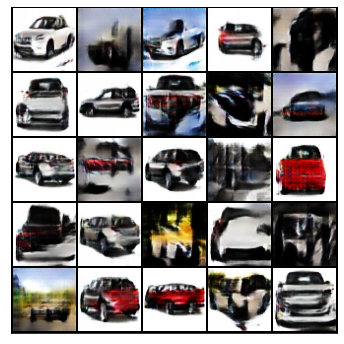

In [17]:
z = Variable(FloatTensor(cp.random.normal(0, 1, (N** 2, latent_size, 1, 1))))
gen_imgs = generator(z)
show_images(gen_imgs.data.cpu(), N**2)

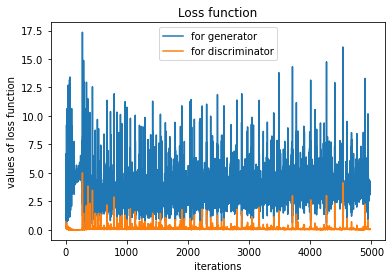

In [18]:
# rysowanie wartosci funkcji straty dla obu klas sieci
number_of_iterations=range(1,number_of_epochs*len(train_dl)+1)
plt.plot(number_of_iterations,g_loss_iteration)
plt.plot(number_of_iterations,d_loss_iteration)
plt.xlabel('iterations')
plt.ylabel('values of loss function')
plt.title('Loss function')
plt.legend(['for generator', 'for discriminator'],loc='best')

In [ ]:
# zapisz wytrenowany model (opcjonalne)
torch.save(generator.state_dict(), './trained_models/generator.pt')

In [ ]:
# zaladuj wytrenowany model (opcjonalne)
generator = Generator().to(device)
generator.load_state_dict(torch.load('./trained_models/generator.pt'))
generator.eval()

In [50]:
# ewaluacja sieci GAN
noise = Variable(FloatTensor(cp.random.normal(0, 1, (40, latent_size, 1, 1))))
generated_imgs = generator(noise)

# wyliczanie FID
dims = 2048 # ile wyjsc fragmentu sieci z InceptionV3
block_idx = inception.InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = inception.InceptionV3([block_idx]).to(device)
loader = DataLoader(train_ds, 30, shuffle=True)
orig_imgs, orig_labels = iter(loader).next()
generated_dist = model(generated_imgs)[0]
orig_dist = model(orig_imgs.to(device))[0]
orig_dist = orig_dist.cpu()
generated_dist = generated_dist.cpu()
fid = calculate_frechet_distance(orig_dist.squeeze().detach().numpy(), 
                                generated_dist.squeeze().detach().numpy())

print(f'Frechet Inception Distance score: {fid}')

# wyliczanie IS
ins = calculate_inception_score(generated_imgs, cuda=cuda, batch_size=30, resize=True, splits=5)
print(f'Inception Score: {ins}')

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

Frechet Inception Distance score: 148.45380160937052


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception Score: 2.8957780153614685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
